# Final Exam Solution

## FINM 37500 - 2023

### UChicago Financial Mathematics

* Mark Hendricks
* hendricks@uchicago.edu

# Instructions

## Please note the following:

Points
* The exam is 150 points.
* You have 180 minutes to complete the exam.
* For every minute late you submit the exam, you will lose one point.
Final Exam

Submission
* You will upload your solution to the Final Exam assignment on Canvas, where you downloaded this.
* Your submission should be readable, (the graders can understand your answers,) and it should include all code used in your analysis in a file format that the code can be executed. (ie. .ipynb preferred, .pdf is unacceptable.)

Rules
* The exam is open-material, closed-communication.
* You do not need to cite material from the course github repo--you are welcome to use the code posted there without citation, (only for this exam.)

Advice
* If you find any question to be unclear, state your interpretation and proceed. We will only answer questions of interpretation if there is a typo, error, etc.
* The exam will be graded for partial credit.

## Data

**All data files are found in the class github repo, in the `data` folder.**

This exam makes use of the following data files:
* `exam_data_2023-05-05.xlsx`

This file has sheets for...
* curve data - discount factors and forward volatilities
* BDT tree of rates (continuously compounded, as usual)

If useful, the following code loads the two sheets:

In [52]:
# FILEIN = '../data/exam_data_2023-05-05.xlsx'
# sheet_curves = 'rate curves'
# sheet_tree = 'rate tree'

# curves = pd.read_excel(FILEIN, sheet_name=sheet_curves).set_index('tenor')
# ratetree = pd.read_excel(FILEIN, sheet_name=sheet_tree).set_index('state')
# ratetree.columns.name = 'time'

## Scoring

| Problem | Points |
|---------|--------|
| 1       | 60     |
| 2       | 30     |
| 3       | 20     |
| 4       | 15     |
| 5       | 15     |
| 6       | 10     |

### Each numbered question is worth 5pts.

# 1. Short Answer

### No Data Needed

These problem does not require any data file. Rather, analyze the situation conceptually, based on the information below. 

A few questions may require simple arithmetic.

## 1.1

Consider a future on a 5-year treasury. If the exchange changes the treasury futures conversion factor to use a 3\% discount instead of 6\%, would you expect substantial changes to the...
* the futures price?
* the forward price of the underlying CTD treasury?

Explain.

**Answer:** If the exhcnage changes the conversion factor to 3 percent discount, then I would expect substantial changes to the futures prices because conversion factors would be a lot higher for coupons greater than 3% with semiannual compounding. This would cause futures prices to be lower. There would not be a change in the forward price underlying the CDT Treasury because pricing the forward has nothing to do with conversion factors. 


## 1.2

Explain how SABR allows for an extra "channel" of delta hedging.


**Answer** Saber allows traders to compute the volatility smile. As the price of the underlying changes, the implied volatility of the option changes to reflect the derivative's moneyneess. So now the price of the option actually changes by delta + vega * $\frac{\partial \sigma_{imp}}{\partial F}$. This gives a better approximation of the *true* delta. 

## 1.3

Local volatility fits quoted volatilities exactly, whereas SABR does not.

What advantage does SABR have over local volatility? How does it relate to the fact above?


SABR's advantage of local volatility has to do with the *bias-variance* trade-off associated with modeling. Local volatility might do a great job at fitting the quoted volatilies, however, out of sample it will perform terribly. SABR's variance at predicting volatilities out of sample is its advantage. 

## 1.4
Relative to three years ago, do you think BDT or Ho-Lee is better suited to today's interest rates?

Explain.

**Answer:** In a higher interest rate environment Ho-Lee is better suited for today's interest rates because the term-structure of interest rates will have analystical properties and the reversion rate is not a function of the volatility parameter.

## 1.5
True or False: To value a caplet in Black's formula, we input the spot interest rate as the underlying.

Explain.

**Answer: False.** To value a caplet in Black's formula we use the forward rate as the underlying asset.



## 1.6
Should we expect a delta-hedged callable bond to underperform or overperform a delta-hedged vanilla bond? Explain.

**Answer:** I expect a delta-hedged callable bond to underperform a delta-hedge vanilla bond because of the call feature. The issue of the callable bond will choose buy back the bond if interest rates fall and issue debt at a lower interest rate. This will make the delta-hedge to be smaller than a plain delta-hedged vanilla bond. 

## 1.7
True or False: In a frictionless market, gross basis and net basis are nonzero before maturity, but they converge to zero for the CTD bond at maturity.

**Answer:True**

## 1.8
True or False: Bonds with higher coupons have larger "forward drops".

**Answer:True**

## 1.9
True or False: We expect that high duration bonds are typically CTD.

**Answer:True**

## 1.10

True or False: If forward volatility is decreasing over maturity then flat volatility is also decreasing over maturity.

**Answer:False**

## 1.11

True or False: From fed funds futures prices, we can extract the probability of interest rate movements for any meeting date.

**Answer:False**

## 1.12

How is Black's model useful---and necessary--- in fixed income derivatives, even if we choose to use a more complex, proprietary model.

**Answer:**
- Black's model allows us to price derivatives using *forward measure*. Under **forward measure**, any derivative for forward is a martingale so we can **discount with today's discount factors rather than a stochastic interest rate.** This greatly simplifies the process of pricing interest rate derivatives. 

***

# 2. Bond Pricing

## 2.1
Use the BDT tree to price a bond.
* Time-to-maturity is 3 years
* Coupon rate is 1\%.

As usual, 
* coupons are paid semiannually.
* face value is $N=100$.

Display the tree of the bond's value, where each node is **as usual** the ex-coupon dirty price. 
* Thus, the value at node 0.5 is just after the coupon was paid.
* The value at node 0.25 includes accrued interest.

In [53]:
import pandas as pd
import datetime as dt
from datetime import timedelta
import numpy as np
from Binomial_Fixed.ficcvol import *
from Binomial_Fixed.binomial import *
from Binomial_Fixed.ratecurves import *
import scipy
from scipy.optimize import fsolve
from scipy.stats import norm
import matplotlib.pyplot as plt
import matplotlib as mpl
plt.style.use('seaborn')
mpl.rcParams['font.family'] = 'serif'
from Binomial_Fixed.treasury_cmds import *

In [54]:
exam_file = 'C:/Users/dcste/OneDrive/Fixed_Income_Derivatives/finm-fiderivs-2023/data/exam_data_2023-05-05.xlsx'
params = pd.read_excel(exam_file,sheet_name=0).set_index('tenor')
ratetree = pd.read_excel(exam_file,sheet_name=1).set_index('state')

In [55]:
# Bond Parameters
T = 3
FACE = 100
cpn = 0.01
dt = .25
compound = int(1/dt)
cpn_freq = 2
Tsteps = int(T/dt)



In [56]:
payoffbond = lambda r: payoff_bond(r, dt, facevalue=FACE*(1+cpn/cpn_freq))
cftree = construct_bond_cftree(T,compound,cpn)

In [57]:
bondtree = bintree_pricing(payoff=payoffbond, ratetree=ratetree.iloc[:Tsteps,:Tsteps], cftree=cftree)
accinttree = construct_accint(timenodes=bondtree.columns, freq = compound, cpn = cpn, cpn_freq=cpn_freq)
clean_tree = np.maximum(bondtree-accinttree,0)

- Below is the bond tree's dirty price

In [58]:
accinttree

0       0.50
0.25    0.25
0.5     0.50
0.75    0.25
1       0.50
1.25    0.25
1.5     0.50
1.75    0.25
2       0.50
2.25    0.25
2.5     0.50
2.75    0.25
dtype: float64

In [59]:
bondtree.dropna(how = 'all').style.format('{:.3f}',na_rep = '')

,0,0.250000,0.500000,0.750000,1,1.250000,1.500000,1.750000,2,2.250000,2.500000,2.750000
state,,,,,,,,,,,,
0,92.852,92.153,91.509,90.377,89.758,88.588,88.036,87.351,87.679,88.105,90.276,93.757
1,,95.906,95.440,94.458,93.953,92.867,92.326,91.529,91.609,91.649,93.157,95.538
2,,,98.372,97.558,97.211,96.277,95.836,95.026,94.941,94.661,95.589,97.053
3,,,,99.702,99.503,98.738,98.449,97.719,97.601,97.134,97.593,98.240
4,,,,,100.964,100.329,100.182,99.564,99.502,99.015,99.247,99.335
5,,,,,,101.149,101.078,100.521,100.494,100.004,100.123,99.919
6,,,,,,,101.522,100.996,100.985,100.493,100.556,100.208
7,,,,,,,,101.230,101.226,100.733,100.769,100.349
8,,,,,,,,,101.348,100.853,100.873,100.418


## 2.2

Display the tree of the bond's **clean price** (still ex-coupon, as usual.)

In [60]:
clean_tree.dropna(how = 'all').style.format('{:3f}', na_rep = '')

,0,0.250000,0.500000,0.750000,1,1.250000,1.500000,1.750000,2,2.250000,2.500000,2.750000
state,,,,,,,,,,,,
0,92.351977,91.903049,91.009178,90.126878,89.257572,88.337786,87.536236,87.100732,87.179338,87.854698,89.775561,93.506586
1,,95.655568,94.939661,94.207881,93.452713,92.616683,91.826352,91.279387,91.109017,91.399374,92.657389,95.288422
2,,,97.872450,97.308177,96.710543,96.026538,95.336482,94.775672,94.440951,94.410943,95.088839,96.803398
3,,,,99.452106,99.002808,98.487503,97.949092,97.468769,97.101289,96.884124,97.093443,97.990211
4,,,,,100.463533,100.079218,99.682041,99.313609,99.001793,98.764994,98.747285,99.084990
5,,,,,,100.899145,100.577838,100.271408,99.993669,99.753553,99.622839,99.668794
6,,,,,,,101.021846,100.745761,100.484712,100.243036,100.056402,99.957728
7,,,,,,,,100.980169,100.726441,100.483195,100.268550,100.098819
8,,,,,,,,,100.847658,100.602707,100.373352,100.168013


## 2.3

Consider a European **put** option on the bond.
* Expiration of the option is 1 year.
* Strike is equal to face value, $100$.
* At exercise, the option holder receives the strike plus accrued interest.

Display the tree of the option price.

In [61]:
strike = 100
expiration = 1
ratetree_deriv = ratetree.loc[:,:expiration]
bondtree_deriv = bondtree.loc[:,:expiration]

payoff_deriv = lambda p : np.maximum(strike - p,0)


In [62]:
optiontree = bintree_pricing(payoff=payoff_deriv, ratetree=ratetree_deriv, undertree=bondtree_deriv)

In [65]:
optiontree.dropna(how = 'all').style.format('{:.3f}', na_rep='')

,0,0.250000,0.500000,0.750000,1
state,,,,,
0,3.157,4.467,6.096,8.014,10.242
1,,1.928,2.965,4.366,6.047
2,,,0.931,1.630,2.789
3,,,,0.247,0.497
4,,,,,0.000


## 2.4

Consider the same option, but this time **American**.

Display the tree of the option price.

In [66]:
option_tree_american = bintree_pricing(payoff=payoff_deriv, ratetree=ratetree_deriv, undertree=bondtree_deriv, style='american')
option_tree_american.dropna(how = 'all').style.format('{:.3f}',na_rep='')

,0,0.250000,0.500000,0.750000,1
state,,,,,
0,7.148,7.847,8.491,9.623,10.242
1,,4.094,4.560,5.542,6.047
2,,,1.628,2.442,2.789
3,,,,0.298,0.497
4,,,,,0.000


## 2.5

Is there a node where the option is in-the-money, yet it is not optimal to exercise? 

Briefly explain, and if so, give an example.

In [68]:
import seaborn as sns

<AxesSubplot:ylabel='state'>

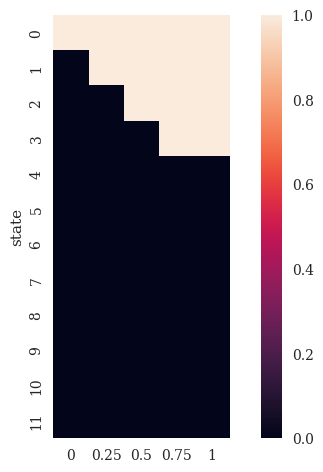

In [69]:
sns.heatmap(exercise_decisions(payoff_deriv,bondtree_deriv, option_tree_american), square=True)

It is theoretically always better to exercise early for this american option. 
* There is no node where it is better to hold onto the option.


## 2.6 

Consider an **amortizing bond** with 
* maturity 2.5 years.
* coupon rate of 40\%.
* Notional of \$100.

Unlike a typical bond, it pays a coupon semiannually, but it does not ever pay the face value. In that sense, one could view the coupons as amortized payments of the face value.

Value the amortizing bond and display the valuation tree.

In [70]:
T = 2.5
amor_coupon = 0.40
construct_bond_cftree(T,(1/dt),cpn = amor_coupon,cpn_freq=2,face = 100)

time,0.00,0.25,0.50,0.75,1.00,1.25,1.50,1.75,2.00,2.25
state,,,,,,,,,,
0,0.0,0.0,20.0,0.0,20.0,0.0,20.0,0.0,20.0,0.0
1,0.0,0.0,20.0,0.0,20.0,0.0,20.0,0.0,20.0,0.0
2,0.0,0.0,20.0,0.0,20.0,0.0,20.0,0.0,20.0,0.0
3,0.0,0.0,20.0,0.0,20.0,0.0,20.0,0.0,20.0,0.0
4,0.0,0.0,20.0,0.0,20.0,0.0,20.0,0.0,20.0,0.0
5,0.0,0.0,20.0,0.0,20.0,0.0,20.0,0.0,20.0,0.0
6,0.0,0.0,20.0,0.0,20.0,0.0,20.0,0.0,20.0,0.0
7,0.0,0.0,20.0,0.0,20.0,0.0,20.0,0.0,20.0,0.0
8,0.0,0.0,20.0,0.0,20.0,0.0,20.0,0.0,20.0,0.0


***

# 3 Floorlet

## 3.1 (5pts)

Consider a **floorlet** with
* Strike is $0.06$
* Notional $N=100$

As usual, the floorlet has a one-quarter lag between when the payoff is determined and when it is received.
* determined at $T=2$
* payoff at $T=2.25$.

Use the BDT tree of rates to value the floorlet. Display the valuation tree.

In [102]:
STRIKE = 0.06
Notional = 100
T_floor = 2.25
steps_floor = int(T_floor/dt)


In [121]:
params['spot_rate'] = discount_to_intrate(params['discounts'], maturity=params.index, n_compound=4)
params['fwd_rate'] = ratecurve_to_forwardcurve(params['spot_rate'], n_compound=4)

In [124]:
# Valuation Tree at Time 2
deriv_tree_

,2,Option_Payoff
state,,
0,0.121216,0.000000
1,0.088359,0.000000
2,0.060902,0.000000
3,0.039690,0.507750
4,0.020349,0.991275
5,0.010122,1.246946
6,0.005083,1.372930
7,0.002627,1.434318
8,0.001424,1.464392


In [123]:
deriv_tree_ = ratetree[[2]].fillna(0)
deriv_tree_['Option_Payoff'] = Notional*dt*np.maximum(STRIKE - deriv_tree_[2],0)
deriv_tree_['Option_Payoff'].mean()*params.loc[T_floor,'discounts']


0.9207640640805799

- A floorlet is the expected discounted interest rate put where the discount factor is applied for tenor T = 2.25 and the payoff is determined at T = 2. 

- Price is $\$0.920764$

## 3.2 (5pts)

Regardless of your price above, assume the market is quoting the floorlet at a price of \$0.80.

Use Black's formula to calculate the implied volatility of this floorlet, supposing the underlying is currently 3.5\%.

In [135]:
def CAP_Floor(spot_rate, strike_rate, volatility,discount,T,dt = .25,N = 1, caplet = True):
    """
    spot_rate : set equal to the forward rate
    strike_rate: set equal to the swap rate
    volatility: flat vol
    discount = discount factor
    T = time to maturity
    dt:  frequency of payments
    N: Notional Value
    """
    d1 = (np.log(spot_rate/strike_rate) + (volatility**2/2)*T)/(volatility*np.sqrt(T))
    d2 = d1 - volatility*np.sqrt(T)
    if caplet == True:
        return N*dt*(discount*(spot_rate*norm.cdf(d1) - strike_rate*norm.cdf(d2)))
    else:
        return N*dt*(discount*(strike_rate*norm.cdf(-d2) - spot_rate*norm.cdf(-d1)))

In [149]:
CAP_Floor(spot_rate=params.loc[2,'fwd_rate'],strike_rate=params.loc[2,'spot_rate'],volatility=.035,discount=params.loc[2,'discounts'],T = 1.75,dt = .25, N = 1, caplet=False)

0.002275098231778253

In [140]:
def wrapper_vol(sigma):

    return .8 - CAP_Floor(spot_rate=params.loc[2,'fwd_rate'],strike_rate=params.loc[2,'spot_rate'],volatility=sigma,discount=params.loc[2,'discounts'],T = 1.75,dt = .25, N = 1, caplet=False)



In [144]:
fsolve(wrapper_vol,.3)

c:\Users\dcste\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


array([30.3])

## 3.3 (5pts)

Based on your answers to 3.1 and 3.2, is the OAS positive or negative? Explain.

## 3.4 (5pts)

Consider a floorlet which pays immediately upon the payoff being determined rather than having the one-quarter lag.

Price this alternate floorlet and display the valuation tree.

***

# 4. Swaps

## 4.1 

Consider a **paying-fixed** swap which resets (and make payments) **quarterly**.
* Maturity is $T=3$
* Notional is $N=100$.
* Swap rate is 3.53\%.
* The floating rate is the quarterly compounded interest rate.

(Recall that paying-fixed means you pay the swap rate and receive the floating rate.)

Display the cashflow tree.

In [150]:
T_swap = 3
N = 100
swap_rate = 0.0353
dt = .25
compound = int(1/dt)
step_swap = int(T/dt)

In [151]:
swap_payoff = lambda r:N*dt*(r-swap_rate)

In [153]:
swap_tree = bintree_pricing(payoff=swap_payoff,ratetree=ratetree.iloc[:step_swap,:step_swap])

## 4.2

Display the value tree.

In [155]:
swap_tree

,0,0.25,0.5,0.75,1,1.25,1.5,1.75,2,2.25
state,,,,,,,,,,
0,-0.179675,-0.001375,0.216194,0.476919,0.782803,1.133083,1.529644,1.982744,2.513284,3.135117
1,NaN,-0.362532,-0.218984,-0.037876,0.186636,0.458157,0.777285,1.142703,1.556320,2.046108
2,NaN,NaN,-0.513644,-0.404994,-0.263290,-0.080441,0.151016,0.436301,0.772673,1.136055
3,NaN,NaN,NaN,-0.630208,-0.553327,-0.450454,-0.313344,-0.131006,0.111367,0.432999
4,NaN,NaN,NaN,NaN,-0.713802,-0.662101,-0.592838,-0.500088,-0.375611,-0.208045
5,NaN,NaN,NaN,NaN,NaN,-0.769401,-0.735333,-0.689853,-0.628927,-0.547008
6,NaN,NaN,NaN,NaN,NaN,NaN,-0.805761,-0.783443,-0.753768,-0.714033
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.829525,-0.814821,-0.795420
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.845161,-0.835292


## 4.3

Consider a **european** swaption, (option to enter into the paying-fixed swap).
* expiration is $T=1$
* there is no strike at exercise.
    - could think of this as a strike of 0
    - but often referred to as a strike of 3.53\%, the fixed rate on the underlying swap
    
Display the swaption valuation tree.

In [161]:
swaption_payoff = lambda p : np.maximum(p,0)
Expiration_Swaption = 1
swap_Tree_2 = swap_tree.loc[:,:Expiration_Swaption]
bintree_pricing(payoff=swaption_payoff,ratetree=ratetree.loc[:,:1],undertree=swap_Tree_2)


,0,0.25,0.5,0.75,1
state,,,,,
0,0.090448,0.160625,0.280257,0.476919,0.782803
1,NaN,0.022565,0.045600,0.092221,0.186636
2,NaN,NaN,0.000000,0.000000,0.000000
3,NaN,NaN,NaN,0.000000,0.000000
4,NaN,NaN,NaN,NaN,0.000000
5,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN


***

# 5. Treasury Futures

## 5.1

Consider a bond with
* Market (clean) price of 97.50
* Futures conversion ratio of 0.95

It has
* Coupon rate of 1\% 
* face value of 100.

As for the coupon timing,
* The bond paid a coupon 38 days ago.
* It will pay another coupon in 144 days.
* The repo rate over the next 90 days is (annualized in the usual way) 5\%.

Calculate the forward price of the bond for delivery in 90 days. 

In [165]:
cpn= .01
FACE = 100
repo = .05
quote = 97.50
nxt_cpn_days = 38
accrued_days_interval = 182
accrued_days = accrued_days_interval - 38
px_dirty = quote + FACE*(cpn/2)*(accrued_days/accrued_days_interval)
Income = FACE*(cpn/2)

accrued_int2 = 144 -90
acrrued_int_after = cpn*(FACE/2)*(accrued_int2)



In [ ]:
def forward_price(clean_price, repo,cpn,curr_date,days_accrued,cpn_date1,delivery_date):
    curr_date = convert_dt(curr_date)
    cpn_date0 = curr_date - dt.timedelta(days = days_accrued)
    cpn_date1 = convert_dt(cpn_date1)
    delivery_date = convert_dt(delivery_date)

    repo = repo/100
    cpn = cpn*(1/2)

    accint = ((curr_date-cpn_date0).days/(cpn_date1-cpn_date0).days)*(cpn)
    dirty_price = clean_price+accint 

    I = cpn*(np.exp(-repo*(cpn_date1-curr_date).days/360))
    # 90 - 
    DTD = (delivery_date-curr_date).days/(360)
    discount = np.exp(repo*DTD)
    accrued_int = cpn*((delivery_date-cpn_date1).days/((cpn_date1+pd.DateOffset(months = 6))-cpn_date1).days)
    F0 = (dirty_price-cpn)*discount - accrued_int

    return F0

## 5.2

Calculate the gross and net basis of the bond.

## 5.3

Suppose you are pricing a futures contract on the 5-year treasury. The contract expires in 1 year, $T=1.

There are three deliverable bonds with the following data,

| Clean Price at $T=1$ | Conversion Factor |
|--------|--------|
| 95.5   | .940   |
| 96.2   | .945   |
| 97.1   | .958   |

***

# 6. Fitting the BDT Tree

Fit a BDT Tree. We will not use it for any other questions on the exam. 


## 6.1
Use the discount rates provided in the data file.

Instead of using the forward volatilities, use a constant $\sigma=0.50$ at every step.

Report the estimated thetas.

## 6.2
Regardless of your previous answer, suppose your estimated thetas are all equal to 0.5.

Display the interest-rate tree.

***